In [2]:
# downloading and unpacking the data
! curl -o data.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip -o data.zip

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273k  100  273k    0     0   165k      0  0:00:01  0:00:01 --:--:--  165k
Archive:  data.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error


## 1. Explorative analysis

In [76]:
hour_data = pd.read_csv('hour.csv')
hour_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [77]:
hour_data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Data contains the following infotmation, according to the description:
- instant: record index 
- dteday : date 
- season : season (1:winter, 2:spring, 3:summer, 4:fall) 
- yr : year (0: 2011, 1:2012) 
- mnth : month ( 1 to 12) 
- hr : hour (0 to 23) 
- holiday : weather day is holiday or not (extracted from [Web Link]) 
- weekday : day of the week 
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. 
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) 
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) 
- hum: Normalized humidity. The values are divided to 100 (max) 
- windspeed: Normalized wind speed. The values are divided to 67 (max) 
- casual: count of casual users 
- registered: count of registered users 
- cnt: count of total rental bikes including both casual and registered 


The column 'instant' may be dropped, as it is just an index and cannot be relevant for the prediction model.

'dteday' is a datetime object. As the relevant information is already extracted from it in other column, we will drop it.

Columns 'casual' and 'registered' are just the components of total count. We will drop them as well, and use the count column as a predicted value.
 
Other columns are potential factors for the model and will be explored on detail.

In [78]:
hour_data.drop(columns=['dteday', 'instant', 'casual', 'registered'], inplace=True)

In [79]:
factors = hour_data.columns.to_list()
factors.remove('cnt')
num_factors = ['temp', 'atemp', 'hum', 'windspeed']
cat_factors = [f for f in factors if f not in num_factors]

In [80]:
def plotFactors(df, col, c_type):
#plots given factor as a distribution and as relation to the target column
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  if c_type == 'cat':
    df[col].value_counts(sort=False).plot(kind='bar', ax=plt.gca())
    plt.subplot(1,2,2)
    df.boxplot('cnt', col, ax=plt.gca())
  elif c_type == 'num':
    df.hist(col, ax=plt.gca())
    plt.subplot(1,2,2)
    df.plot.scatter(col, 'cnt', ax=plt.gca(), s=0.1)
  plt.show()

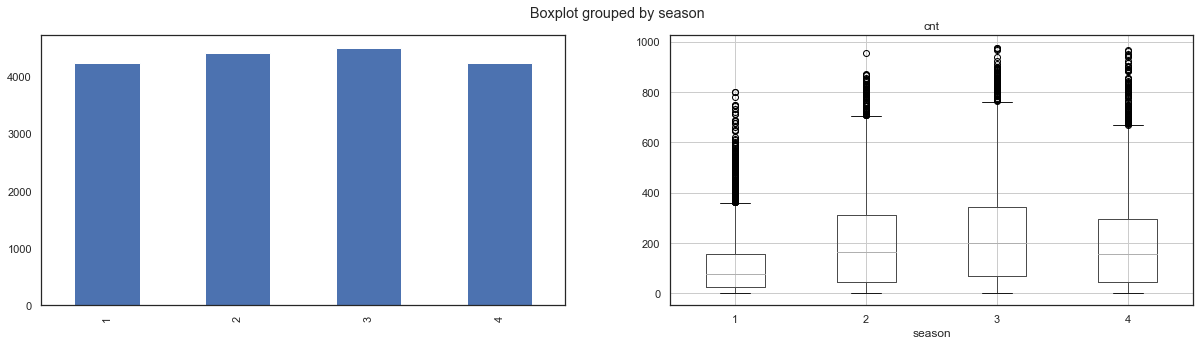

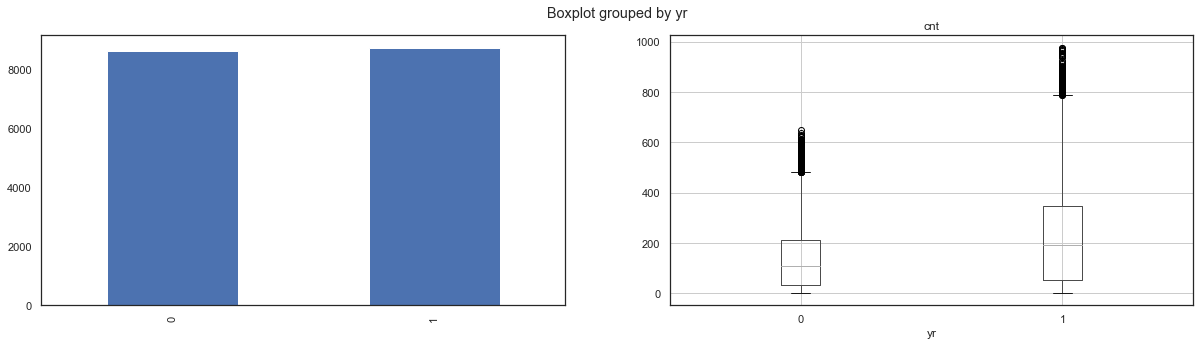

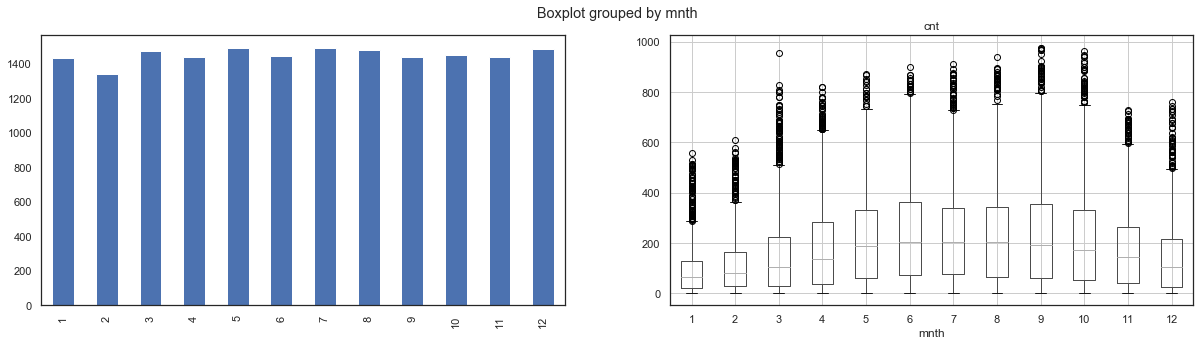

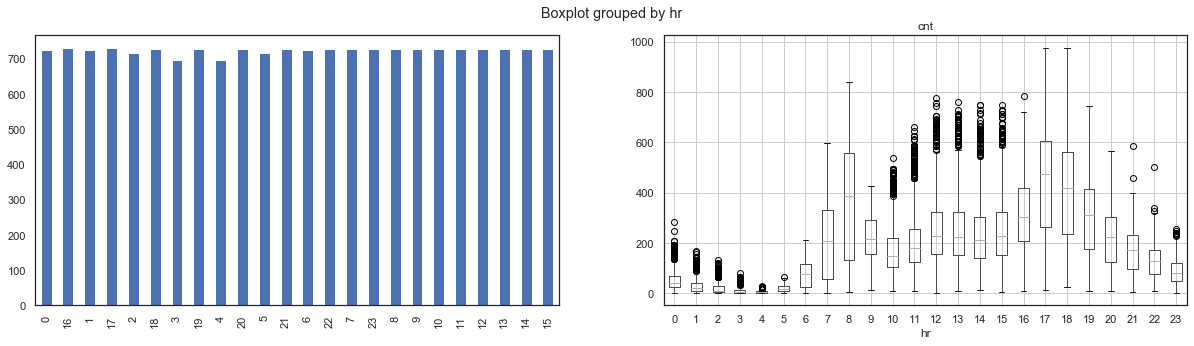

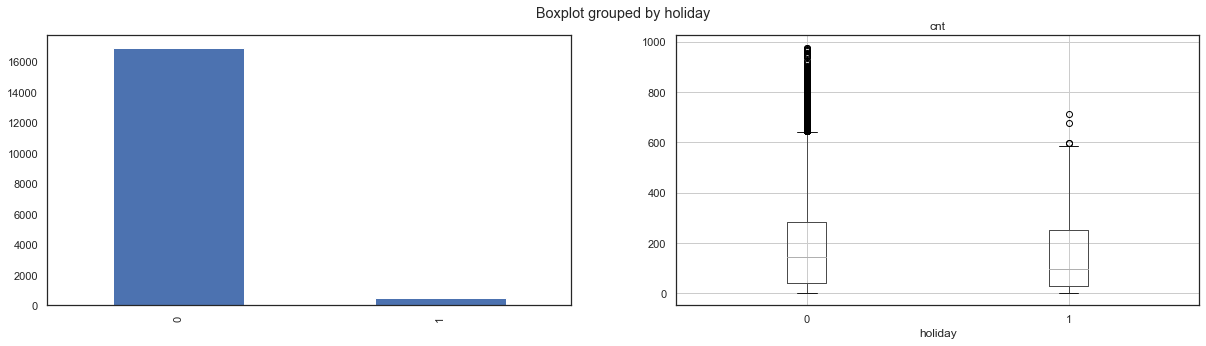

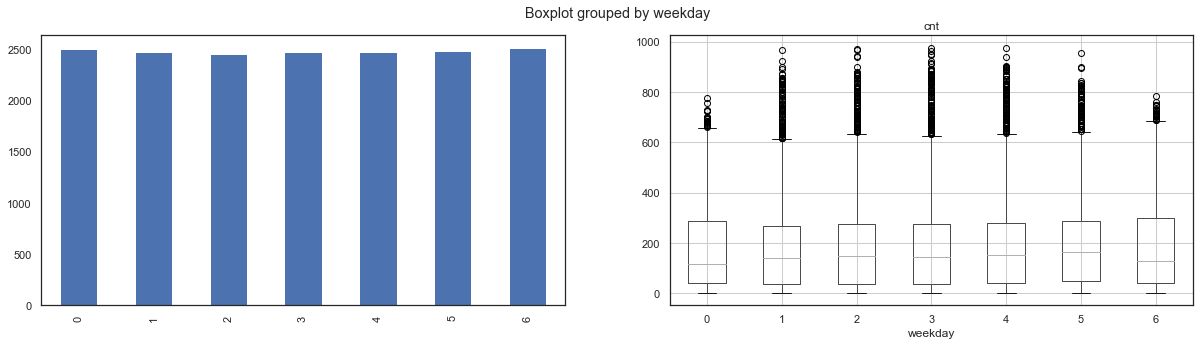

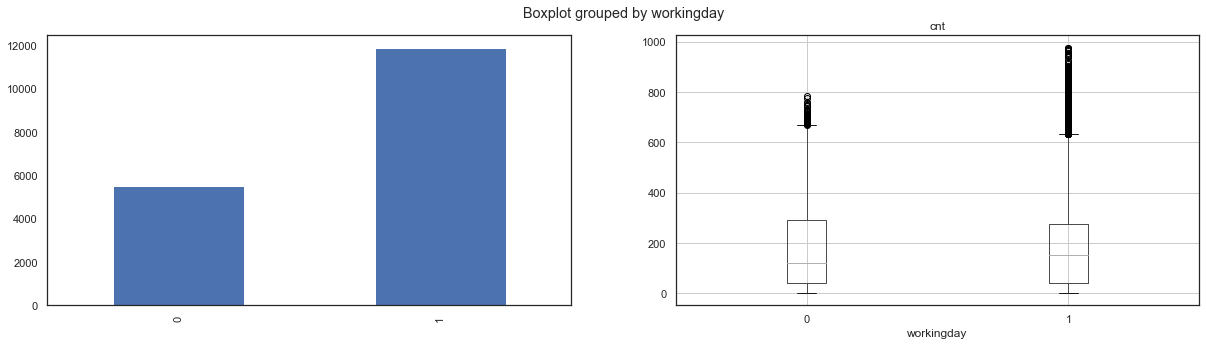

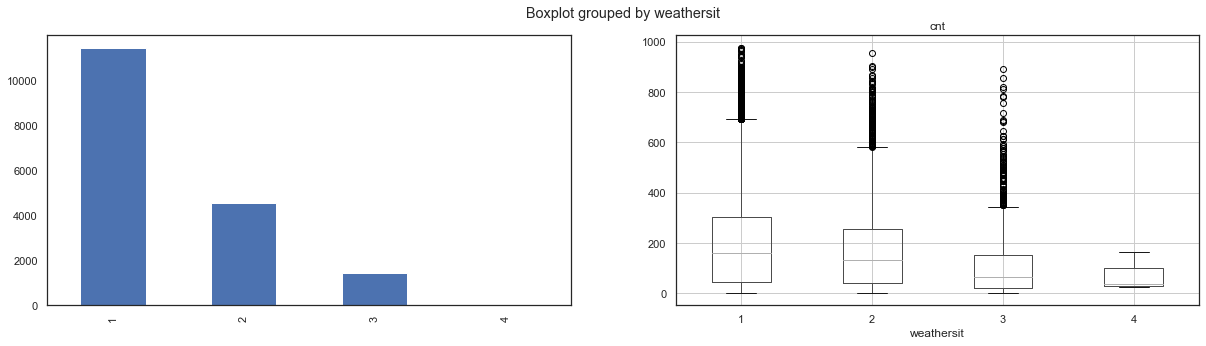

In [81]:
#visualising categorical factors
for f in cat_factors:
  plotFactors(hour_data, f, 'cat')

Some patterns can be already seen in these graphs. 
Counts are higher during summer, than in winter.
There are also clear peak hours around 9 a.m. and 5 p.m.
More rentals occur on working days, than on weekens and holidays.
There is also an obvious correlation with weather conditions.
In the 2nd year the number of rentals significantly grew.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


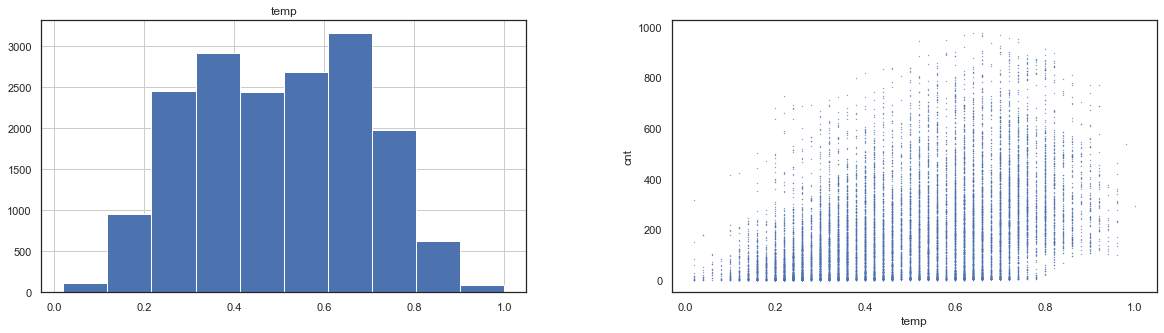

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


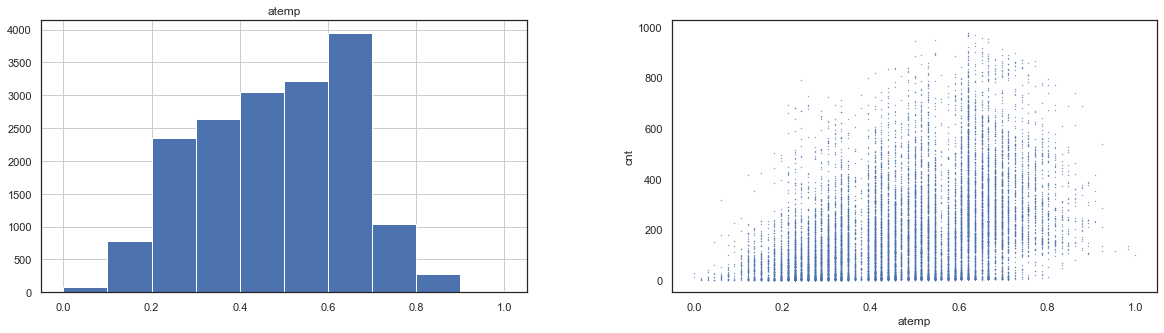

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


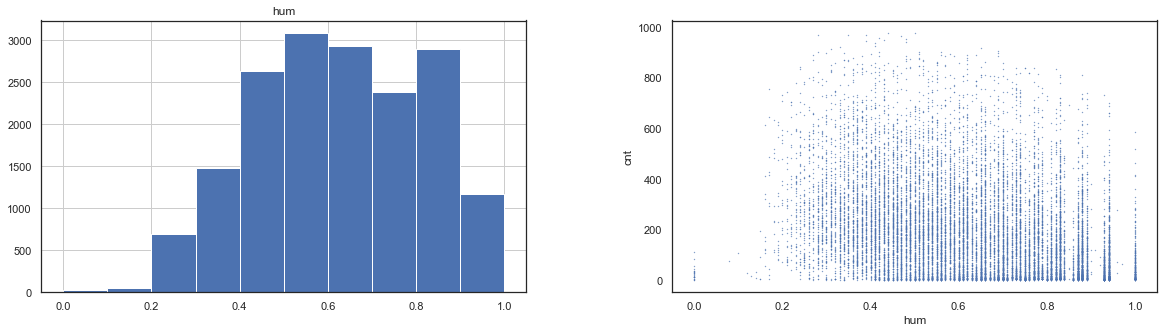

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


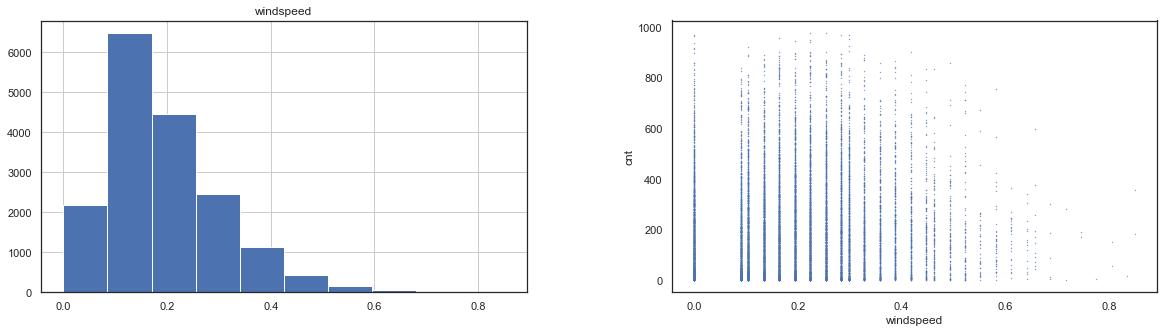

In [82]:
#visualising numeric factors
for f in num_factors:
  plotFactors(hour_data, f, 'num')

The numeric factors are all weather-related.
We can see some negative linear trend with windspeed, which is not the case with the other factors.
More comfortable weather conditions for bike rental would rather be in the middle of temperature and humidity scale.
Therefore, trying to fit these factors to a linear model wouldn't be the best idea.

Next we discover correlations beetwen the factors in the data.

In [83]:
def drawCorrelations(df):
  sns.set(style="white")
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  f, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



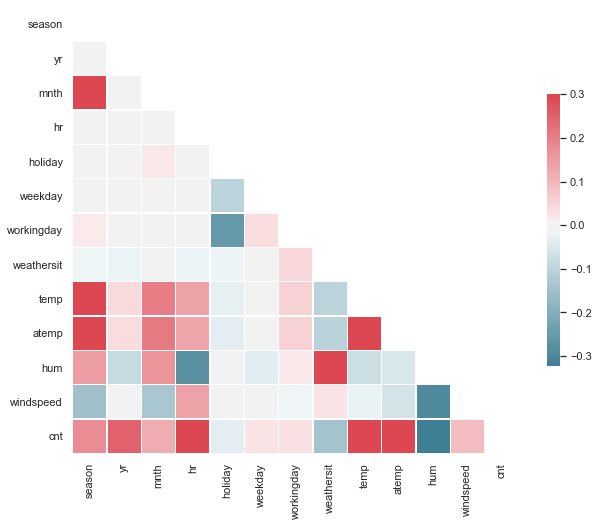

In [84]:
drawCorrelations(hour_data)

Count of rentals is most strongly correlated with hour, year, temperature, and humidity.

There are some logical correlations between month and season, temerature and season, as well as temperature and perceived temperature. 

Even though the months are stongly correlated with seasons, we won't drop any of these column, since there is some overlapping in the data.


## 2. Model selection and fitting

Dataset is split into train and test (80:20).
Test set will be hold out and only used to validate the final model

In [89]:
X = hour_data.drop('cnt', axis=1)
y = hour_data.cnt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

All factors available in the datases are either time or weather related. 
There are not many factors, which are linearly correlated with the count, there is a lot of seasonal trends in the data, when it comes to time of the day, seasons or temperature.

So we will not consider linear regression models.

As we have a combination of numeric and categorical features, a good soluntion would be to use a tree-based model.

One of the most effecient tree algorythms for structured data is Extreme Gradient Boosting, which normally outperforms CART, random forests, or gradinet boosting.

It is also scalable, can use GPU and be parralelized, in case we need to build a model on a large dataset.



The model is XGBRegressor with absolute error as a metric.
We will use grid search to tune the hyperarameters. Grid search includes cross-validation

In [123]:
base_model = xgb.XGBRegressor()

parameters = {'objective':['reg:squarederror'],  # default objective function for regression
              'learning_rate': [.01, .05, .07],  # step size shrinkage
              'max_depth': [5, 10, 15],          # max depth of each tree, lower values tend to overfit
              'min_child_weight': [3, 5 ,8, 12], # building stops, when a node less than the value
              'subsample': [0.7],                # subsample ratio of training instances to prevent overfitting
              'n_estimators': [100, 200, 500],   # number of trees
              'lambda': [0, 1, 2]                # L2 regularization term
                                              
             }  


grid = GridSearchCV(base_model,
                     parameters,
                     cv = 2,
                     n_jobs = -1,
                     verbose=True)

grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  6.4min finished


0.9482195816783849
{'lambda': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 8, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.7}


Final model, fitting again to the complete train dataset:

In [124]:
model = grid.best_estimator_
#fitting the complete train set to the model again
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', lambda=0, learning_rate=0.05,
             max_delta_step=0, max_depth=10, min_child_weight=8, missing=None,
             n_estimators=200, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, verbosity=1)

Getting mean absolute scores for train and test datasets:

In [125]:
#prediction for train
pred_train = model.predict(X_train)
mae_train = mean_absolute_error(pred_train, y_train)
print('Train MAE: %f' % (mae_train))

#prediction for test
pred_test = model.predict(X_test)
pred_test = 
mae_test = mean_absolute_error(pred_test, y_test)
print('Test MAE: %f' % (mae_test))

Train MAE: 12.639487
Test MAE: 22.776756


Importance of single features:

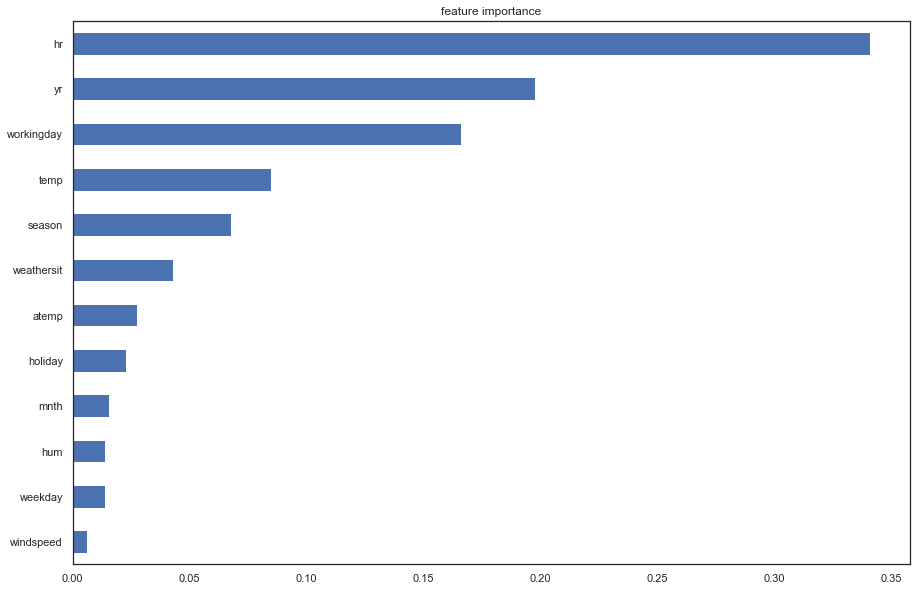

In [126]:
importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values()
plt.figure(figsize=(15,10))
importance.plot(kind='barh', title='feature importance')